## Setup

In [1]:
# set working directory
setwd("/Genomics/pritykinlab/adina/bulkrna-differential-analysis/agt7")

In [2]:
# load libraries
library(SummarizedExperiment)
library(DESeq2)
library(pheatmap)
library(ggplot2)

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges, rowRanks,
    rowSdDiffs, rowSds, rowSums2, ro

In [3]:
# create function to normalize counts in deseq object

# assume rowRanges is a non-empty GRangesList and size factors were already computed (ex: using estimateSizeFactors())
normCounts <- function(se) {
  gene_length <- sum(width(rowRanges(se)))
  counts_norm <- apply(counts(se, normalized = TRUE), 2, 
                       function(x) {
                         1e3 * x / gene_length
                       })
  assays(se)$counts_norm <- counts_norm
  return(se)
}


In [4]:
# get functions from other files

# function to create a deseq dataset
source("/Genomics/pritykinlab/adina/bulkrna-differential-analysis/functions_and_snippets/create_deseq_dataset.R")

# function to get de genes
source("/Genomics/pritykinlab/adina/bulkrna-differential-analysis/functions_and_snippets/get_de_genes.R")


Attaching package: ‘glue’


The following object is masked from ‘package:SummarizedExperiment’:

    trim


The following object is masked from ‘package:GenomicRanges’:

    trim


The following object is masked from ‘package:IRanges’:

    trim




## Read data

In [5]:
# read in data

# define the root directory
root = "/Genomics/pritykinlab/share/eileen-rnaseq/processed"

# read in gene expression data
gene_counts <- readRDS(glue('{root}/AGT7-rna-counts.raw.rds'))

# read in gencode
gencode <- readRDS(glue('{root}/mm10_gencode.rds'))

# read in metadata
metadata <- read.csv(glue('{root}/agt7_metadata_cleaned.csv'), check.names = FALSE)


## Preprocess data

In [6]:
# prepare collection of all protein-coding exons for genes in gencode
exons <- gencode[(gencode$gene_type == 'protein_coding') & (gencode$type == 'exon')]
genes <- levels(as.factor(exons$gene_name))
exons_genes <- disjoin(split(exons, factor(exons$gene_name, levels = genes)))


In [7]:
# save the gene counts counts data in a dataframe
gene_counts_df <- as.data.frame(gene_counts$counts)

# fix the column headers of the gene counts data
names(gene_counts_df) <- gsub(".bam", "", names(gene_counts_df))

# put gene counts into a matrix
gene_counts_mat <- as.matrix(gene_counts_df)

# sort the gene names
gene_names <- sort(names(exons_genes))

# order gene_counts_mat according to sorted rownames
gene_counts_mat <- gene_counts_mat[gene_names, ]

# sort exons_genes
exons_genes <- exons_genes[gene_names]


In [8]:
# replace spaces in header of metadata with underscore
names(metadata) <- gsub(" ", "_", names(metadata))

# change Mouse_Genotype_Code column from W/M to WT/KO
metadata$Mouse_Genotype_Code[metadata$Mouse_Genotype_Code=='W'] <- 'WT'
metadata$Mouse_Genotype_Code[metadata$Mouse_Genotype_Code=='M'] <- 'KO'

# relabel the gender of 2DarkATG7KO2585-59-Liver to female instead of male (based on Xist gene analysis)
metadata[metadata$filename == "2DarkATG7KO2585-59-Liver",]$Gender <- "Female"

# set the rownames of the metadata to be the sample names
rownames(metadata) <- metadata$filename

# change columns from characters to factors
metadata$Collection_Cycle <- as.factor(metadata$Collection_Cycle)
metadata$Gender <- as.factor(metadata$Gender)
metadata$Weeks_Post_Deletion <- as.factor(metadata$Weeks_Post_Deletion)
metadata$Mouse_Genotype_Code <- as.factor(metadata$Mouse_Genotype_Code)

# view the beginning of the metadata
head(metadata)


,filename,Collection_Cycle,Gender,Mouse_ID,Weeks_Post_Deletion,Mouse_Genotype_Code,tissue
,<chr>,<fct>,<fct>,<int>,<fct>,<fct>,<chr>
12DarkATG7KOfemale1911-21-GNP,12DarkATG7KOfemale1911-21-GNP,Dark,Female,1911,12,KO,GNP
12DarkATG7KOfemale1911-22-iWAT,12DarkATG7KOfemale1911-22-iWAT,Dark,Female,1911,12,KO,iWAT
12DarkATG7KOfemale1911-23-BAT,12DarkATG7KOfemale1911-23-BAT,Dark,Female,1911,12,KO,BAT
12DarkATG7KOfemale1911-24-Liver,12DarkATG7KOfemale1911-24-Liver,Dark,Female,1911,12,KO,Liver
12DarkATG7KOfemale1911-25-Cerebellum,12DarkATG7KOfemale1911-25-Cerebellum,Dark,Female,1911,12,KO,Cerebellum
12DarkATG7KOfemale1914-26-GNP,12DarkATG7KOfemale1914-26-GNP,Dark,Female,1914,12,KO,GNP


In [9]:
# sort the gene_counts_mat to be in the same order as the metadata
# IMPORTANT: the order of the columns of gene_counts_mat needs to be the same as the order of the rows of the metadata!
gene_counts_mat <- gene_counts_mat[, metadata$filename]



In [10]:
# confirm that rows of metadata match columns of gene_counts_mat
all(rownames(metadata) == colnames(gene_counts_mat))


[1] TRUE

## Liver data

In [11]:
# set condition where tissue is liver and remove inaccurate sample
liver_cond <- (metadata$tissue == "Liver") & (metadata$Mouse_ID != "2028")

# get subset of gene_counts_mat where tissue is liver
gene_counts_mat_liver <- gene_counts_mat[, metadata[liver_cond, ]$filename]

# get subset of metadata where tissue is liver
metadata_liver <- metadata[liver_cond, ]


In [12]:
# confirm that rows of metadata for liver match columns of gene_counts_mat for liver
all(rownames(metadata_liver) == colnames(gene_counts_mat_liver))


[1] TRUE

In [13]:
# create summarized experiment object for liver
gene_counts_se_liver <- SummarizedExperiment(list(counts = gene_counts_mat_liver), rowRanges = exons_genes)

# combine summarized experiment object with metadata
colData(gene_counts_se_liver) <- cbind(colData(gene_counts_se_liver), metadata_liver)

# remove genes on sex chromosome
gene_counts_se_liver_no_sex <- gene_counts_se_liver[all(!seqnames(gene_counts_se_liver) %in% c("chrX", "chrY"))]


In [14]:
# deseq (no adjustors)

# use create_deseq_dataset() to create deseq object from summarized experiment object
dds_liver_no_adj <- create_deseq_dataset(gene_counts_se_liver_no_sex, "Mouse_Genotype_Code")

# get top 5000 genes
normalized_counts_liver <- dds_liver_no_adj$normalized_counts[order(-rowMeans(dds_liver_no_adj$normalized_counts)), ][1:5000, ]


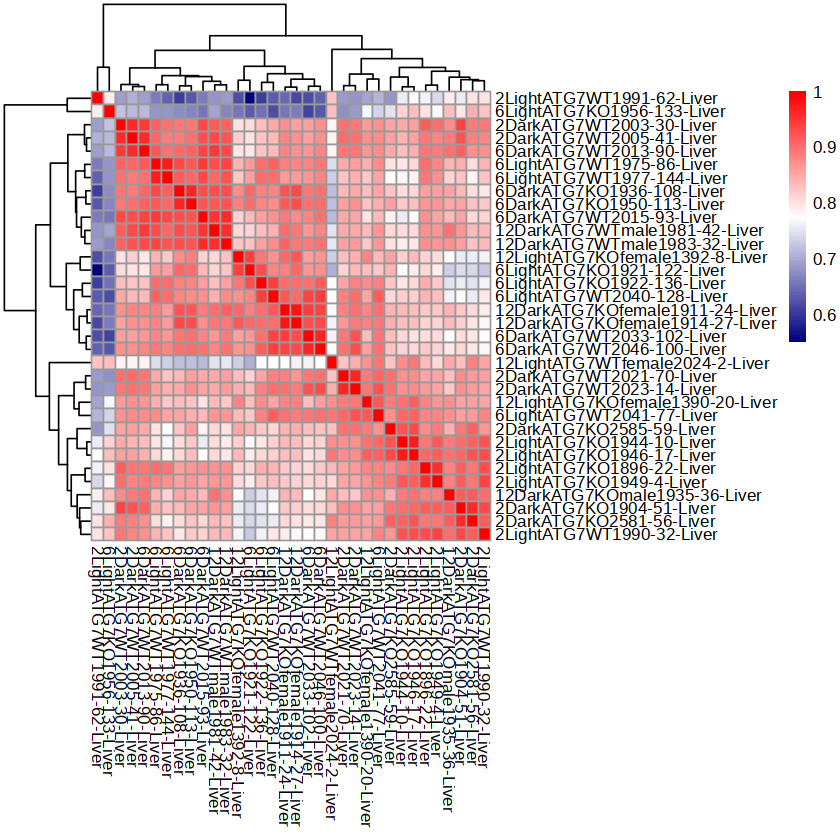

In [15]:
# heatmap samples

# get normalized counts correlation
normalized_counts_cor_liver <- cor(normalized_counts_liver, method = "spearman")

# create heatmap
pheatmap(normalized_counts_cor_liver, color = colorRampPalette(c("navy", "white", "red"))(100))


## DESeq

In [16]:
# deseq (no adjustors)

# use get_de_genes() to get de genes (deseq object created above)
res_liver_no_adj <- get_de_genes(dds_liver_no_adj$dds, "Mouse_Genotype_Code", "KO", "WT")

# sort results
res_liver_no_adj_ordered <- res_liver_no_adj$res[order(res_liver_no_adj$res$padj),]

# view the results
View(as.data.frame(res_liver_no_adj_ordered))

# save results to csv file
write.csv(as.data.frame(res_liver_no_adj_ordered), file = "res_liver_no_adj_ordered.csv")


using pre-existing size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 204 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Gstm3,5309.63749,4.125048,0.2332056,17.688460,5.146251e-70,7.982865e-66
Cbr3,402.47105,5.741581,0.3295314,17.423474,5.475001e-68,4.246411e-64
Rnaset2b,196.59571,4.810827,0.2999290,16.039884,6.728031e-58,3.478841e-54
A2ml1,103.31605,-2.671522,0.1879301,-14.215512,7.341227e-46,2.846928e-42
Rsad2,2839.78022,4.811334,0.3519023,13.672359,1.485022e-42,4.607133e-39
Oasl1,1086.54214,3.530899,0.2655193,13.298088,2.374630e-40,6.139211e-37
Gstm1,44239.30661,2.105828,0.1633372,12.892520,4.959650e-38,1.099058e-34
Slc1a1,211.94709,6.166380,0.5084631,12.127486,7.553234e-34,1.464572e-30
Cxcl10,322.12247,3.497287,0.3135440,11.154054,6.841669e-29,1.179200e-25


In [17]:
# deseq (adjusted for gender)

# use create_deseq_dataset() to create deseq object from summarized experiment object
dds_liver_adj_gender <- create_deseq_dataset(gene_counts_se_liver_no_sex, "Mouse_Genotype_Code", "Gender")

# use get_de_genes() to get de genes
res_liver_adj_gender <- get_de_genes(dds_liver_adj_gender$dds, "Mouse_Genotype_Code", "KO", "WT")

# sort results
res_liver_adj_gender_ordered <- res_liver_adj_gender$res[order(res_liver_adj_gender$res$padj),]

# view the results
View(as.data.frame(res_liver_adj_gender_ordered))

# save results to csv file
write.csv(as.data.frame(res_liver_adj_gender_ordered), file = "res_liver_adj_gender_ordered.csv")


using pre-existing size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 49 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Cbr3,402.47105,5.680663,0.3208214,17.706623,3.727788e-70,5.782545e-66
Gstm3,5309.63749,4.085120,0.2346635,17.408419,7.122323e-68,5.524074e-64
Rnaset2b,196.59571,4.808939,0.3025787,15.893185,7.064557e-57,3.652847e-53
Rsad2,2839.78022,4.756612,0.3348146,14.206705,8.325186e-46,3.228507e-42
A2ml1,103.31605,-2.627243,0.1866485,-14.075885,5.343169e-45,1.657665e-41
Oasl1,1086.54214,3.454009,0.2570402,13.437619,3.639603e-41,9.409587e-38
Nqo1,373.51363,2.398359,0.1830553,13.101830,3.214144e-39,7.122544e-36
Gstm1,44239.30661,2.125149,0.1643795,12.928306,3.116095e-38,6.042109e-35
Cxcl10,322.12247,3.471828,0.2854256,12.163689,4.851704e-34,8.362181e-31


## PCA

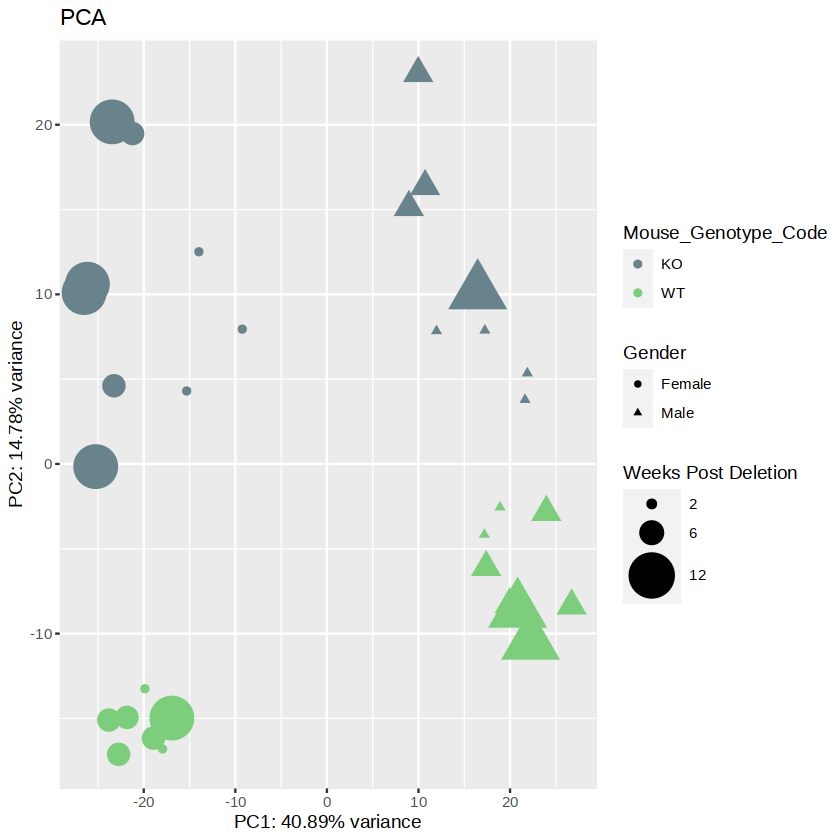

In [18]:
# pca plot (no adjustors)

# transform data to use in plot
vsd <- varianceStabilizingTransformation(dds_liver_no_adj$dds, blind = FALSE)

# create PCA plot
pcaData_liver <- plotPCA(vsd, intgroup = c("Mouse_Genotype_Code", "Gender", "Weeks_Post_Deletion"), returnData = TRUE)

# get the percent variance from PCA plot
percentVar <- round(100 * attr(pcaData_liver, "percentVar"), digits = 2)

# format plot
ggplot(pcaData_liver, aes(x = PC1, y = PC2, color = Mouse_Genotype_Code, shape = Gender)) + 
    geom_point(aes(size = Weeks_Post_Deletion)) +
    scale_size_manual(values = c(2, 6, 12)) + 
    labs(x = paste0("PC1: ", percentVar[1], "% variance"),
         y = paste0("PC2: ", percentVar[2], "% variance"),
         color = "Mouse_Genotype_Code",
         shape = "Gender",
         size = "Weeks Post Deletion") +
    scale_color_manual(values = c("lightblue4", "palegreen3")) +
    guides(color = guide_legend(order = 1), shape = guide_legend(order = 2), size = guide_legend(order = 3)) +
    ggtitle("PCA")


## Heatmap genes

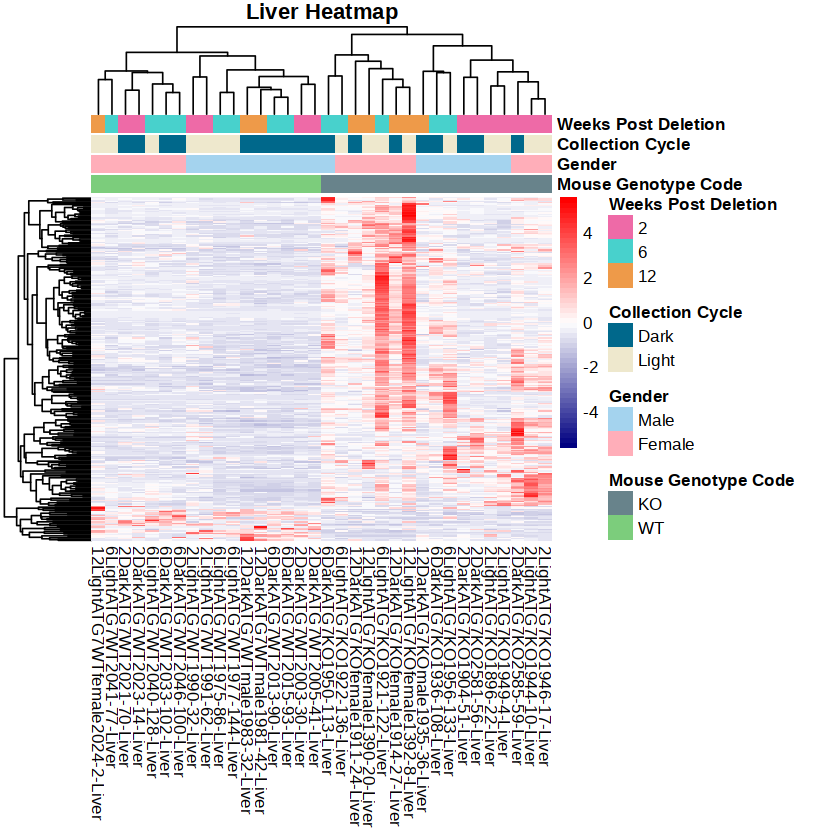

In [19]:
# heatmap genes (no adjustors)

# get subset of results where padj < 0.05
res_liver_hm_no_adj <- subset(res_liver_no_adj_ordered, padj < 0.05)

# sort results into descending LFC
res_liver_hm_no_adj <- res_liver_hm_no_adj[abs(res_liver_hm_no_adj$log2FoldChange) > 1, ]

# convert results to a dataframe
res_liver_hm_no_adj_df <- as.data.frame(res_liver_hm_no_adj)

# get counts that correspond to significant genes
mat_liver_hm_no_adj <- counts(dds_liver_no_adj$dds, normalized = TRUE)[rownames(res_liver_hm_no_adj_df), ]

# create dataframe for annotations
samples_list_liver_no_adj <- colnames(mat_liver_hm_no_adj)
samples_list_liver_no_adj_df <- metadata_liver[metadata_liver$filename %in% samples_list_liver_no_adj,]
samples_list_liver_no_adj_df_tmp <- data.frame(samples_list_liver_no_adj_df[, c('Mouse_Genotype_Code', "Gender", "Collection_Cycle", "Weeks_Post_Deletion")])
rownames(samples_list_liver_no_adj_df_tmp) <- samples_list_liver_no_adj_df$filename
samples_list_liver_no_adj_df <- samples_list_liver_no_adj_df_tmp
colnames(samples_list_liver_no_adj_df) <- c('Mouse Genotype Code', "Gender", "Collection Cycle", "Weeks Post Deletion")

# create list of annotation colors
ann_colors_liver_no_adj <- list("Mouse Genotype Code" = c(KO = "lightblue4", WT = "palegreen3"),
                           Gender = c(Male = "lightskyblue2", Female = "lightpink1"),
                           "Collection Cycle" = c(Dark = "deepskyblue4", Light = "cornsilk2"),
                           "Weeks Post Deletion" = c("2" = "hotpink2", "6" = "mediumturquoise", "12" = "tan2"))

# heatmap
# do not need separate z score scaling if use scale = "row" in pheatmap
pheatmap(mat_liver_hm_no_adj, scale = "row", color = colorRampPalette(c("navy", "white", "red"))(50), 
         annotation_col = samples_list_liver_no_adj_df, show_rownames = FALSE, annotation_colors = ann_colors_liver_no_adj, 
         clustering_distance_cols = "correlation", main = "Liver Heatmap")


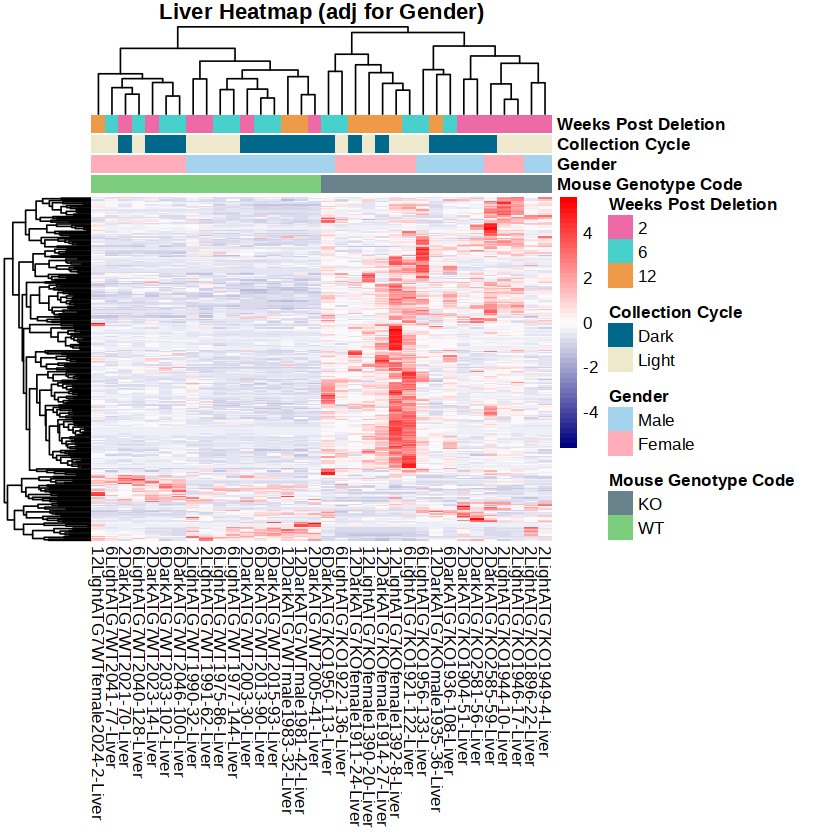

In [20]:
# heatmap genes (adj for gender)

# get subset of results where padj < 0.05
res_liver_hm_adj_gender <- subset(res_liver_adj_gender_ordered, padj < 0.05)

# sort results into descending LFC
res_liver_hm_adj_gender <- res_liver_hm_adj_gender[abs(res_liver_hm_adj_gender$log2FoldChange) > 1, ]

# convert results to a dataframe
res_liver_hm_adj_gender_df <- as.data.frame(res_liver_hm_adj_gender)

# get counts that correspond to significant genes
mat_liver_hm_adj_gender <- counts(dds_liver_adj_gender$dds, normalized = TRUE)[rownames(res_liver_hm_adj_gender_df), ]

# create dataframe for annotations
samples_list_liver_adj_gender <- colnames(mat_liver_hm_adj_gender)
samples_list_liver_adj_gender_df <- metadata_liver[metadata_liver$filename %in% samples_list_liver_adj_gender,]
samples_list_liver_adj_gender_df_tmp <- data.frame(samples_list_liver_adj_gender_df[, c('Mouse_Genotype_Code', "Gender", "Collection_Cycle", "Weeks_Post_Deletion")])
rownames(samples_list_liver_adj_gender_df_tmp) <- samples_list_liver_adj_gender_df$filename
samples_list_liver_adj_gender_df <- samples_list_liver_adj_gender_df_tmp
colnames(samples_list_liver_adj_gender_df) <- c('Mouse Genotype Code', "Gender", "Collection Cycle", "Weeks Post Deletion")

# create list of annotation colors
ann_colors_liver_adj_gender <- list("Mouse Genotype Code" = c(KO = "lightblue4", WT = "palegreen3"),
                           Gender = c(Male = "lightskyblue2", Female = "lightpink1"),
                           "Collection Cycle" = c(Dark = "deepskyblue4", Light = "cornsilk2"),
                           "Weeks Post Deletion" = c("2" = "hotpink2", "6" = "mediumturquoise", "12" = "tan2"))

# heatmap
# do not need separate z score scaling if use scale = "row" in pheatmap
pheatmap(mat_liver_hm_adj_gender, scale = "row", color = colorRampPalette(c("navy", "white", "red"))(50), 
         annotation_col = samples_list_liver_adj_gender_df, show_rownames = FALSE, annotation_colors = ann_colors_liver_adj_gender, 
         clustering_distance_cols = "correlation", main = "Liver Heatmap (adj for Gender)")
